In [4]:
#Imports
import cv2
import glob
import numpy as np 
from matplotlib import pyplot as plot 
from matplotlib import image as image
import easygui 

In [5]:
#Global variables
letter_to_img = {}
letters = "ABCDEFGJLMNOPRTUV"

In [6]:
#Function to add all letter found in folder "./Images/Letter-Images/*.png" into an array of images
#This array of images is then added to a dictionary to reference the value 
def create_letter_image_dict():
    letterimages = [cv2.imread(file) for file in glob.glob("./Images/Letter-Images/*.png")]
    for index in range(0, len(letterimages)):
        letter_to_img[letters[index]] = letterimages[index]

In [7]:
def imageViewerPOPOUT(imagename, img):
    print("Window opened!")
    cv2.imshow(imagename, img)
#For manual closing of windows
    key = cv2.waitKey(0)
#For automatic closing of windows
#     key = cv2.waitKey(80)
#     cv2.destroyWindow(imagename)
    print("Window closed")

In [382]:
def convert_To_RGB(img):
    RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return RGB

def convert_To_GrayScale(img):
    GRAY = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return GRAY

def canny_edge_Detection(I, lowvalue, highvalue):
    FilteredImage = cv2.Canny(I, threshold1=lowvalue, threshold2=highvalue)
    return FilteredImage

def sobel_edge_detection(I):
    Ix = cv2.Sobel(I,ddepth=cv2.CV_64F,dx=1,dy=0)
    Iy = cv2.Sobel(I,ddepth=cv2.CV_64F,dx=0,dy=1)
    FilteredImage = cv2.magnitude(Ix, Iy)
    subplot_images([I,Ix,Iy,FilteredImage])
    return FilteredImage


def calc_subplot(amount):
    if amount == 1:
        return 1,1
    
    for i in range(1,amount):
        if amount % i == 0:
            cols = int(amount / i)
            rows = i
    
    return rows, cols

def subplot_images(Images):
    amount = len(Images)
    rows, columns  = calc_subplot(amount)

    fig=plot.figure(figsize=(16, 16))
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        if(len(Images[i-1].shape)!=3):
            plot.imshow(Images[i-1], cmap='gray')
        else:
            plot.imshow(convert_To_RGB(Images[i-1]))
        
    plot.show()
    

def multiple_thresholding(I, rangelower, rangehigher):
    B = cv2.inRange(I, rangelower, rangehigher)
    return B

def adaptive_thresholding(I, bsize, c):
    B = cv2.adaptiveThreshold(
        I, 
        maxValue = 255,               
        adaptiveMethod = cv2.ADAPTIVE_THRESH_MEAN_C, 
        thresholdType = cv2.THRESH_BINARY,
        blockSize = bsize, 
        C = c)
    return B

def denoisingFunction(img):
    dst = cv2.fastNlMeansDenoising(img,None,15, 15, 15)
    return dst 

def histogram_equalize(img):
    H = cv2.equalizeHist(img)
    return H

In [8]:
def resizeImg(img):
    h, w, d = img.shape
    h1 = int(h/4)
    w1 = int(w/4)
    S = cv2.resize(img, dsize=(h1, w1))
    return S

In [492]:
def main():
    create_letter_image_dict()
    easygui.msgbox("Please select a image")
    f = easygui.fileopenbox()

    if(f == None ):
        while(f == None):
            print("Error reading in file")
            easygui.msgbox("Please select a file")
            f = easygui.fileopenbox()
        
    I = cv2.imread(f)
    ReisizedImg = resizeImg(I)
    Cropped = crop_lid(ReisizedImg)
    Mask = mask_lid(Cropped)
    alter_useby_date(Cropped, Mask)
    
#     imageViewerPOPOUT("Image selected", ReisizedImg)

In [493]:
def crop_lid(Mooju):
    I = Mooju.copy()
    BlurredCopy = cv2.GaussianBlur(I, (7,7), 0)
    CannnyImage = canny_edge_Detection(BlurredCopy, 0, 255)
    
    contours,_ = cv2.findContours(CannnyImage, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    x,y,w,h = cv2.boundingRect(contours[0])
    crop_img = I[y:y+h, x:x+w]
    
#     I = cv2.drawContours(I, contours, -1, color=(0,0,0), thickness=3)
#     subplot_images([CannnyImage, BlurredCopy, I, crop_img])
    return crop_img

In [494]:
def mask_lid(Cropped):
    GRAY = convert_To_GrayScale(Cropped)
    low = 85
    high = 255
    RemoveWhite = multiple_thresholding(GRAY, low, high)
    RemoveWhite = cv2.bitwise_not(RemoveWhite)
    ROI = cv2.bitwise_and(Cropped,Cropped,mask=RemoveWhite)
#     subplot_images([Cropped, RemoveWhite, ROI])
    GRAYROI = convert_To_GrayScale(ROI)
    low = 30
    high = 255
    RemoveBlue = multiple_thresholding(GRAYROI, low, high)
    RemoveBlue = ~RemoveBlue
    
    TextROI = cv2.bitwise_and(ROI, ROI, mask=RemoveBlue)
    TextROI = convert_To_GrayScale(TextROI)
#     SobelImg = sobel_edge_detection(RemoveBlue)
    SobelImg = sobel_edge_detection(TextROI)
#     subplot_images([RemoveBlue, ROI, TextROI])
#     subplot_images([TextROI, RemoveBlue, SobelImg])
    return SobelImg

In [501]:
def alter_useby_date(Cropped, Edges):
    h,w = Edges.shape

    left_corner_x = 0
    left_corner_y = 0
    right_corner_x = 0
    right_corner_y = 0

    
    for x in range(0, w):
        for y in range(0, h):
            if(Edges[y,x] > 0):
                if(left_corner_x > x):
                    left_corner_x = x
                if(left_corner_y > y):
                    left_corner_y = y
                if(right_corner_x < x):
                    right_corner_x = x
                if(right_corner_y < y):
                    right_corner_y = y


#     print(left_corner_x, left_corner_y)
#     print(right_corner_x, right_corner_y)
    
    newlycroppedimage = Cropped[left_corner_y: right_corner_y, left_corner_x: right_corner_x]
    newlycroppedmask = Edges[left_corner_y: right_corner_y, left_corner_x: right_corner_x]
    subplot_images([newlycroppedimage, newlycroppedmask])
    
    newlycroppedmask = newlycroppedmask.astype(np.uint8)
    contours,_ = cv2.findContours(newlycroppedmask, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    Image = cv2.drawContours(newlycroppedimage, contours, -1, color=(0,69,255), thickness=1)
    
    
    cv2.imwrite("croppedimage.jpg", Image)

In [502]:
def testmain():
#     MoojuLids = [cv2.imread(file) for file in glob.glob("./Images/MoojuLids/*.png")]
    Mooju = cv2.imread("./Images/MoojuLids/mooju.jpg")
    ReisizedImg = resizeImg(Mooju)
    Cropped = crop_lid(ReisizedImg)
    GRAY = convert_To_GrayScale(Cropped)
#     HSV = cv2.cvtColor(Cropped, cv2.COLOR_BGR2HSV)
#     YUV = cv2.cvtColor(Cropped, cv2.COLOR_BGR2YUV)
#     subplot_images([Cropped, GRAY, HSV, YUV])
    #Get the mask of the white 
    #low = 80
    #high = 255
    low = 85
    high = 255
    RemoveWhite = multiple_thresholding(GRAY, low, high)
    RemoveWhite = cv2.bitwise_not(RemoveWhite)
    ROI = cv2.bitwise_and(Cropped,Cropped,mask=RemoveWhite)
    subplot_images([Cropped, RemoveWhite, ROI])
#     #Get the mask of the blue and you should be left with the black 

#     GRAYROI = convert_To_GrayScale(ROI)
# #     DefaultCanny = canny_edge_Detection(ROI, 0, 255)
#     DefaultSobel = sobel_edge_detection(GRAYROI)
    
#     subplot_images([DefaultSobel])
    
    GRAYROI = convert_To_GrayScale(ROI)
#     GRAYNOISED = denoisingFunction(GRAYROI)
    low = 30
    high = 255
    RemoveBlue = multiple_thresholding(GRAYROI, low, high)
    RemoveBlue = ~RemoveBlue
    
    TextROI = cv2.bitwise_and(ROI, ROI, mask=RemoveBlue)
    TextROI = convert_To_GrayScale(TextROI)
#     SobelImg = sobel_edge_detection(RemoveBlue)
    SobelImg = sobel_edge_detection(TextROI)
    subplot_images([RemoveBlue, ROI, TextROI])
    subplot_images([TextROI, RemoveBlue, SobelImg])
    
    
    h,w = TextROI.shape

    leftcornery = 0
    leftcornerx = 0
    rightcornery = 0
    rightcornerx = 0
    
    for x in range(0, w):
        for y in range(0, h):
            if(TextROI[y,x] > 0):
                if(leftcornerx > x):
                    leftcornerx = x
                if(leftcornery > y):
                    leftcornery = y
                if(rightcornery < y):
                    rightcornery = y
                if(rightcornerx < x):
                    rightcornerx = x

    print(leftcornerx, leftcornery)
    print(rightcornerx, rightcornery)
    
    newlycroppedimage = Cropped[leftcornery: rightcornery, leftcornerx: rightcornerx]
    newlycroppedmask = SobelImg[leftcornery: rightcornery, leftcornerx: rightcornerx]
    subplot_images([newlycroppedimage, newlycroppedmask])
    
    newlycroppedmask = newlycroppedmask.astype(np.uint8)
    contours,_ = cv2.findContours(newlycroppedmask, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    Image = cv2.drawContours(newlycroppedimage, contours, -1, color=(0,69,255), thickness=1)
    
    
    cv2.imwrite("croppedimage.jpg", Image)
    

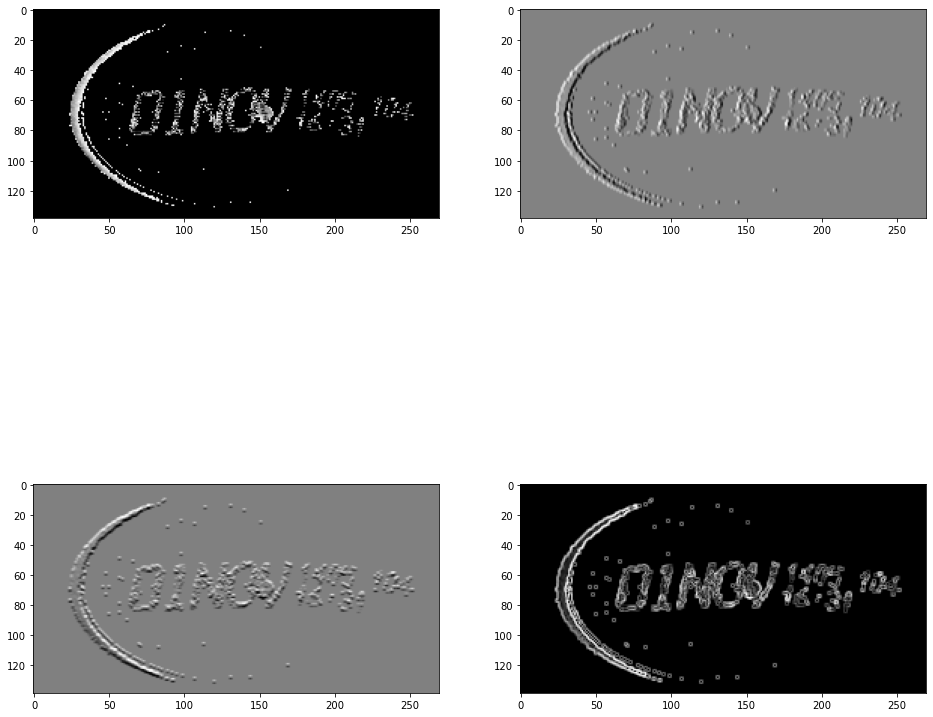

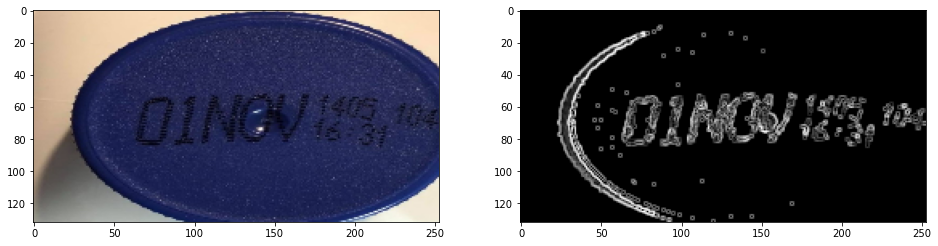

In [506]:
#This runs when program is started
if __name__ == "__main__":
    main()

#This is for testing all lids 
#     MoojuLids = [cv2.imread(file) for file in glob.glob("./Images/MoojuLids/*.jpg")]
#     for Mooju in MoojuLids:
#     testmain()

        